In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

from simple_autodiff.engine import Tensor, sigmoid
from simple_autodiff.nn import MLP

np.random.seed(1)

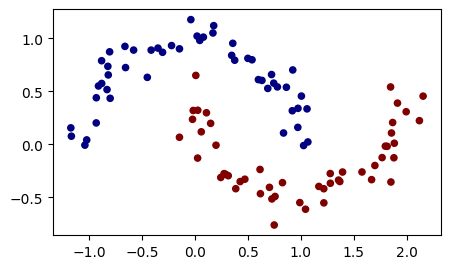

In [2]:
# make up a dataset
X, y = make_moons(n_samples=100, noise=0.1)

# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='jet')
plt.gca().set_aspect('equal');

In [3]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", sum(np.prod(p.data.shape) for p in model.parameters()))

MLP of [ReLU layer of width 16, ReLU layer of width 16, linear layer of width 1]
number of parameters 337


In [4]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = Tensor(Xb)
    
    # forward the model to get scores
    scores = model(inputs)

    # compute cross entropy loss
    losses = scores.sigmoid_cross_entropy(yb)
    data_loss = losses.sum() / losses.data.shape[0]
    
    # add L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum(((p ** 2).sum() for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = (yb[:, None] > 0) == (scores.data > 0)
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Tensor(data=[[1.79988544]], grad=[[0.]]) [0.5]


In [5]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9 * k / 100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc * 100}%")

step 0 loss [[1.79988544]], accuracy [50.]%
step 1 loss [[4.04287599]], accuracy [50.]%
step 2 loss [[0.73964797]], accuracy [80.]%
step 3 loss [[0.30083852]], accuracy [87.]%
step 4 loss [[0.2825416]], accuracy [89.]%
step 5 loss [[0.27500048]], accuracy [87.]%
step 6 loss [[0.26911266]], accuracy [88.]%
step 7 loss [[0.26527]], accuracy [87.]%
step 8 loss [[0.26165002]], accuracy [88.]%
step 9 loss [[0.25636685]], accuracy [89.]%
step 10 loss [[0.25073625]], accuracy [91.]%
step 11 loss [[0.24630649]], accuracy [90.]%
step 12 loss [[0.24242518]], accuracy [91.]%
step 13 loss [[0.23925905]], accuracy [90.]%
step 14 loss [[0.23477849]], accuracy [92.]%
step 15 loss [[0.23083907]], accuracy [90.]%
step 16 loss [[0.22538469]], accuracy [92.]%
step 17 loss [[0.22106042]], accuracy [91.]%
step 18 loss [[0.21575965]], accuracy [92.]%
step 19 loss [[0.2112371]], accuracy [91.]%
step 20 loss [[0.20666868]], accuracy [92.]%
step 21 loss [[0.20256606]], accuracy [91.]%
step 22 loss [[0.19865509

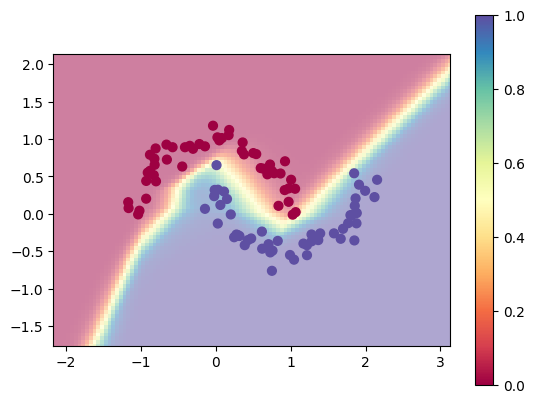

In [6]:
# visualize predictive density
h = 0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = Tensor(Xmesh)
scores = model(inputs)
probs = sigmoid(scores.data)
probs = probs.reshape(xx.shape)

fig = plt.figure()
plt.pcolormesh(xx, yy, probs, alpha=0.5, cmap=plt.cm.Spectral)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.colorbar()
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.gca().set_aspect('equal');